In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [107]:
class Orbit:
    """ 
        Orbit(omega, Omega, l, e, p, m1, m2, f=0):
    
            Encodes the orbit of a binary pair with masses m1 and m2. The orbit is parametrized by the masses of the bodies,
            the eccentricity e, and the semi-latus rectum p. The orbital plane is described by three angles Omega, omega and l.
            The evolution of the orbit is measured with respect to the true anomaly f. By default, the starting anomaly is set to f=0.
            
            see [Gravity, Newtonian, post-Newtonian, Relativistic. E. Poisson and C. M. Will. Cambridge University. Chapter 3]
    
        ************************************************************************************************************************************
            
            Methods:
            
                distance():
                    Returns the lenght of the radial vector.
                    output: float 32
                
                position_unit():
                    Returns the unit vector along the radial direction.
                    output: float 32, shape (3,)
                
                position():
                    Returns the position vector.
                    output: float 32, shape (3,)
            
                periastrum_unit():
                    Returns the unit vector along the direction to the periastrum.
                    output: float 32, shape (3,)
                    
                lambdavector():
                    Returns the unit vector lambda orthogonal to the position vector in the orbital plane.
                    output: float 32, shape (3,)
                    
                zvector():
                    Returns the unit vector orthogonal to the orbital plane.
                    output: float 32, shape (3,)
            
                time_step(delta, steps=1):
                    input: float, int
                    Performs *steps* time steps in orbital evolution, each with time lenght delta. This is done by using the oscullating formalism,
                    with the orbital parameters evolving according to param(t+delta)=(dparam/dt)*delta.
                    
                set_force(R,S,W):
                    input: function, function, function
                    Sets the force perturbation to a specific function shape. The force vector is decomposed according to the criteria in
                    [Gravity, Newtonian, post-Newtonian, Relativistic. E. Poisson and C. M. Will. Cambridge University. Chapter 3]
                
                force():
                    Returns the force vector.
                    output: float 32, shape (3,)
            
     
    """
    
    def __init__(self, omega, Omega, l, e, p, m1, m2, f=0):
        self.l=l
        self.Omega=Omega
        self.omega=omega
        self.f=f
        self.e=e
        self.p=p
        self.a=p/(1-e**2)
        self.t=0
        self.M=m1+m2
        self.G=1
        
        self.R=lambda : 0
        self.S=lambda : 0
        self.W=lambda : 0
        
    def distance(self):
        return self.p/(1+self.e*np.cos(self.f))
    
    def position(self):
        return self.distance()*self.position_unit()
    
    def position_unit(self):
        return np.array([self.__xcoord(),self.__ycoord(),self.__zcoord()],dtype='float32')
    
    def __xcoord(self):
        return np.cos(self.Omega)*np.cos(self.omega+self.f)-np.cos(self.l)*np.sin(self.Omega)*np.sin(self.omega+self.f)
    
    def __ycoord(self):
        return np.sin(self.Omega)*np.cos(self.omega+self.f)+np.cos(self.l)*np.cos(self.Omega)*np.sin(self.omega+self.f)
    
    def __zcoord(self):
        return np.sin(self.l)*np.sin(self.omega+self.f)        
    
    def lambdavector(self):
        return np.array([-np.cos(self.Omega)*np.sin(self.omega+self.f)-np.cos(self.l)*np.sin(self.Omega)*np.cos(self.omega+self.f),
                 -np.sin(self.Omega)*np.sin(self.omega+self.f)+np.cos(self.l)*np.cos(self.Omega)*np.cos(self.omega+self.f),
                  np.sin(self.l)*np.cos(self.omega+self.f)
                 ],dtype='float32')
    
    def zvector(self):
        return np.array([np.sin(self.l)*np.sin(self.Omega),
                        -np.sin(self.l)*np.cos(self.Omega),
                         np.cos(self.l)
                        ],dtype='float32')
    
    def periastrum_unit(self):
        return np.array([np.cos(self.Omega)*np.cos(self.omega)-np.cos(self.l)*np.sin(self.Omega)*np.sin(self.omega),
                        np.sin(self.Omega)*np.cos(self.omega)+np.cos(self.l)*np.cos(self.Omega)*np.sin(self.omega),
                        np.sin(self.l)*np.sin(self.omega)],dtype='float32')
    
    
    
    
    def time_step(self, delta, steps=1):
        for step in range(steps):
            
            deltaf=np.sqrt(self.G*self.M/self.p**3)*(1+self.e*np.cos(self.f))
            deltap=2*np.sqrt(self.p**3/(self.G*self.M))*1/(1+self.e*np.cos(self.f))*self.S()
            deltae=np.sqrt(self.p/(self.G*self.M))*(np.sin(self.f)*self.R() +(2*np.cos(self.f)+self.e*(1+np.cos(self.f)**2))/(1+self.e*np.cos(self.f))*self.S())
            deltal=np.sqrt(self.p/(self.G*self.M))*(np.cos(self.omega+self.f)*self.W()/(1+self.e*np.cos(self.f)))
            deltaOmega=(np.sqrt(self.p/(self.G*self.M))*self.W()*np.sin(self.omega+self.f)/(1+self.e*np.cos(self.f)))/np.sin(self.l)
            deltaomega=np.sqrt(self.p/(self.G*self.M))*(1/self.e)*(-np.cos(self.f)*self.R() + (2+self.e*np.cos(self.f))*np.sin(self.f)*self.S()/(1+self.e*np.cos(self.f)) 
                                                                  -(self.e/np.tan(self.l))*self.W()*np.sin(self.omega+self.f)/(1+self.e*np.cos(self.f)) )
            
            self.t+=delta
            self.f+=deltaf*delta
            self.p+=deltap*delta
            self.e+=deltae*delta
            self.l+=deltal*delta
            self.Omega=deltaOmega*delta
            self.omega=deltaomega*delta
            self.a=self.p/(1-self.e**2)
    

    
    def set_force(self,R,S,W):
        if R is not None:
            self.R=R
        if S is not None:
            self.S=S
        if W is not None:
            self.W=W
            
    def force(self):
        return self.R()*self.position_unit()+self.S()*self.lambdavector()+self.W()*self.zvector()
       
        


In [119]:
orbita=Orbit(omega=1, 
             Omega=1, 
             l=1, 
             e=0.4, 
             p=1, 
             m1=1, 
             m2=1)

In [120]:
rs=np.array(orbita.distance())
thetas=np.array(orbita.omega+orbita.f)

In [110]:
orbita.force()

array([-0.7002264 , -0.5502898 ,  0.45460322], dtype=float32)

In [109]:
orbita.set_force(None,orbita.distance,None)

In [105]:
orbita.time_step(0.01)

In [82]:
orbita.periastrum_unit()

array([-0.09064712,  0.70029646,  0.70807344], dtype=float32)

In [121]:
for step in range(600):
    orbita.time_step(0.01)
    rs=np.append(rs,orbita.distance())
    thetas=np.append(thetas,orbita.omega+orbita.f)

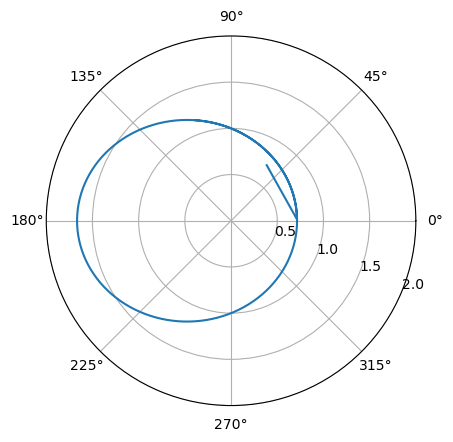

In [122]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(thetas, rs)
ax.set_rmax(2)
ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
ax.grid(True)

plt.show()